In [57]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import re

from itertools import islice
from typing import Dict, Tuple
from wordcloud import WordCloud, STOPWORDS

In [7]:
datafile_path = "../data/02_intermediate/cleaned_data.json"
with open(datafile_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)

In [8]:
df.columns

Index(['post_was_edited', 'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request', 'requester_received_pizza',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')

In [9]:
def clean_text(input_text:str, lowercase: bool = True) -> str:
    """
    Clean text by removing urls, RT, and @mentions, hashtags and extra spaces.
    The text is also lowercased.

    Parameters
    ----------
    input_text : str
        The text to clean.
    lowercase : bool
        Whether to lowercase the text. Default is True.

    Returns
    -------
    str
        The cleaned text.
    """
    if lowercase:
        input_text = input_text.lower()
    txt = re.sub('http\S+\s*', ' ', input_text)  # remove URLs
    txt = re.sub('RT|cc', ' ', txt)  # remove RT and cc
    txt = re.sub('#\S+', '', txt)  # remove hashtags
    txt = re.sub('@\S+', '  ', txt)  # remove mentions
    txt = re.sub('\s+', ' ', txt)  # remove extra whitespace
    return txt

In [10]:
# apply the cleaning function to the text column
df["cleaned_text"] = df['request_text_edit_aware'].apply(clean_text)

In [29]:
def create_wordcloud(text_series: pd.Series,) -> WordCloud:
    """
    Create a wordcloud from a text series.

    Parameters
    ----------
    text_series : pd.Series
        The text series to create the wordcloud from.

    Returns
    -------
    WordCloud
        The wordcloud.
    """
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=50,
        max_font_size=40,
        random_state=42
    )
    wordcloud.generate(text_series.str.cat(sep=' '))
    return wordcloud


def plot_wordcloud(wordcloud: WordCloud, title: str) -> None:
    """
    Plot a wordcloud.

    Parameters
    ----------
    wordcloud : WordCloud
        The wordcloud to plot.
    title : str
        The title of the plot.
    """
    plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.title(title, fontsize=24)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

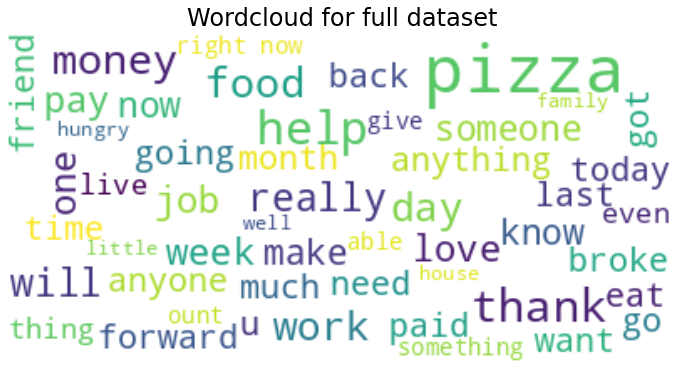

In [30]:
# Wordcloud for full dataset
wordcloud = create_wordcloud(df['cleaned_text'])
plot_wordcloud(wordcloud, 'Wordcloud for full dataset')

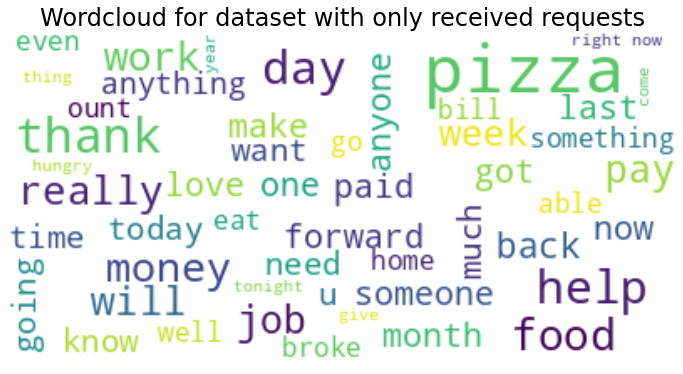

In [31]:
# Wordcloud for dataset with only received requests
wordcloud_positive = create_wordcloud(df[df["requester_received_pizza"] == True]["cleaned_text"])
plot_wordcloud(wordcloud_positive, 'Wordcloud for dataset with only received requests')

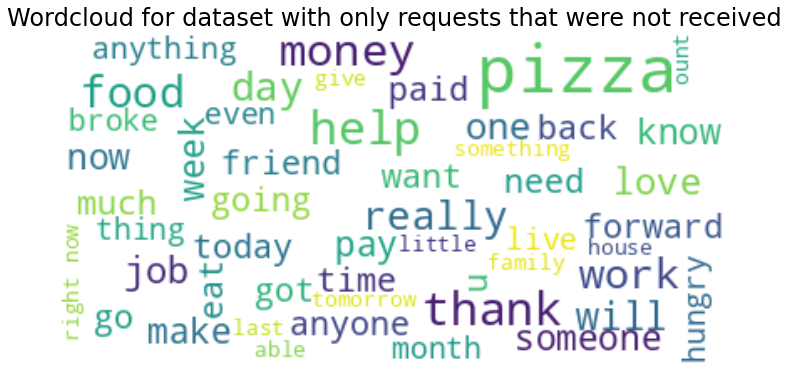

In [32]:
# Wordcloud for dataset with only requests that were not received
wordcloud_negative = create_wordcloud(df[df["requester_received_pizza"] == False]["cleaned_text"])
plot_wordcloud(wordcloud_negative, 'Wordcloud for dataset with only requests that were not received')

In [63]:
def create_text_dictionary_from_wordcloud(text:str) -> dict:
    """
    Create a dictionary of words and their frequencies from a wordcloud.

    Parameters
    ----------
    text : str
        The text to create the dictionary from.

    Returns
    -------
    dict
        The dictionary of words and their frequencies.
    """
    dictionary = wordcloud.process_text(text)
    return {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=True)}


def remove_keys_in_both_dicts(dict1: Dict[str, int], dict2: Dict[str, int]) -> Tuple[Dict, Dict]:
    """
    Remove keys in both dicts.

    Parameters
    ----------
    dict1 : dict
        The first dictionary.
    dict2 : dict
        The second dictionary.

    Returns
    -------
    Tuple[dict, dict]
        The first and second dictionaries with the keys removed.
    """
    keys_in_both_dicts = set(dict1.keys()) & set(dict2.keys())
    for key in keys_in_both_dicts:
        del dict1[key]
        del dict2[key]
    return dict1, dict2


def plot_top_n_words(dictionary: dict, num: int) -> None:
    """
    Plot the top 10 words in a dictionary.

    Parameters
    ----------
    dictionary : dict
        The dictionary to plot the top 10 words from.
    num : int
        The number of words to plot.
    """
    top_10 = list(islice(dictionary.items(), num))
    plt.figure(figsize=(12, 12))
    plt.barh(range(num), [x[1] for x in top_10], align='center')
    plt.yticks(range(num), [x[0] for x in top_10])
    plt.xlabel("Frequency")
    plt.title(f"Top {num} words")
    plt.show()

In [64]:
positive_requests_dictionary = create_text_dictionary_from_wordcloud(df[df["requester_received_pizza"] == True]["cleaned_text"].str.cat(sep=' '))
negative_requests_dictionary = create_text_dictionary_from_wordcloud(df[df["requester_received_pizza"] == False]["cleaned_text"].str.cat(sep=' '))

cleaned_positive_dictionary, cleaned_negative_dictionary = remove_keys_in_both_dicts(positive_requests_dictionary, negative_requests_dictionary)

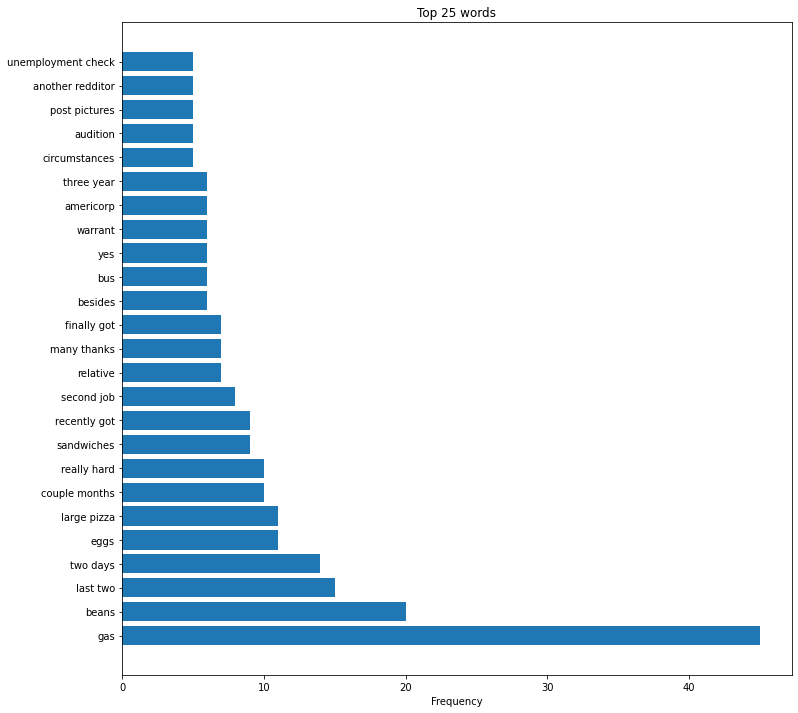

In [66]:
plot_top_n_words(cleaned_positive_dictionary, 25)